In [1]:
import numpy as np
import pandas as pd
from format_data import *
from plots import *

In [110]:
Db=pd.read_excel('table.xlsx')
Db = Db.rename(columns={"Yield strength / MPa": 'output'})
features = list(set(Db.columns)-set(MECHANICAL_PROPERTIES))
Db=Db[features]
print(len(Db.columns))

40


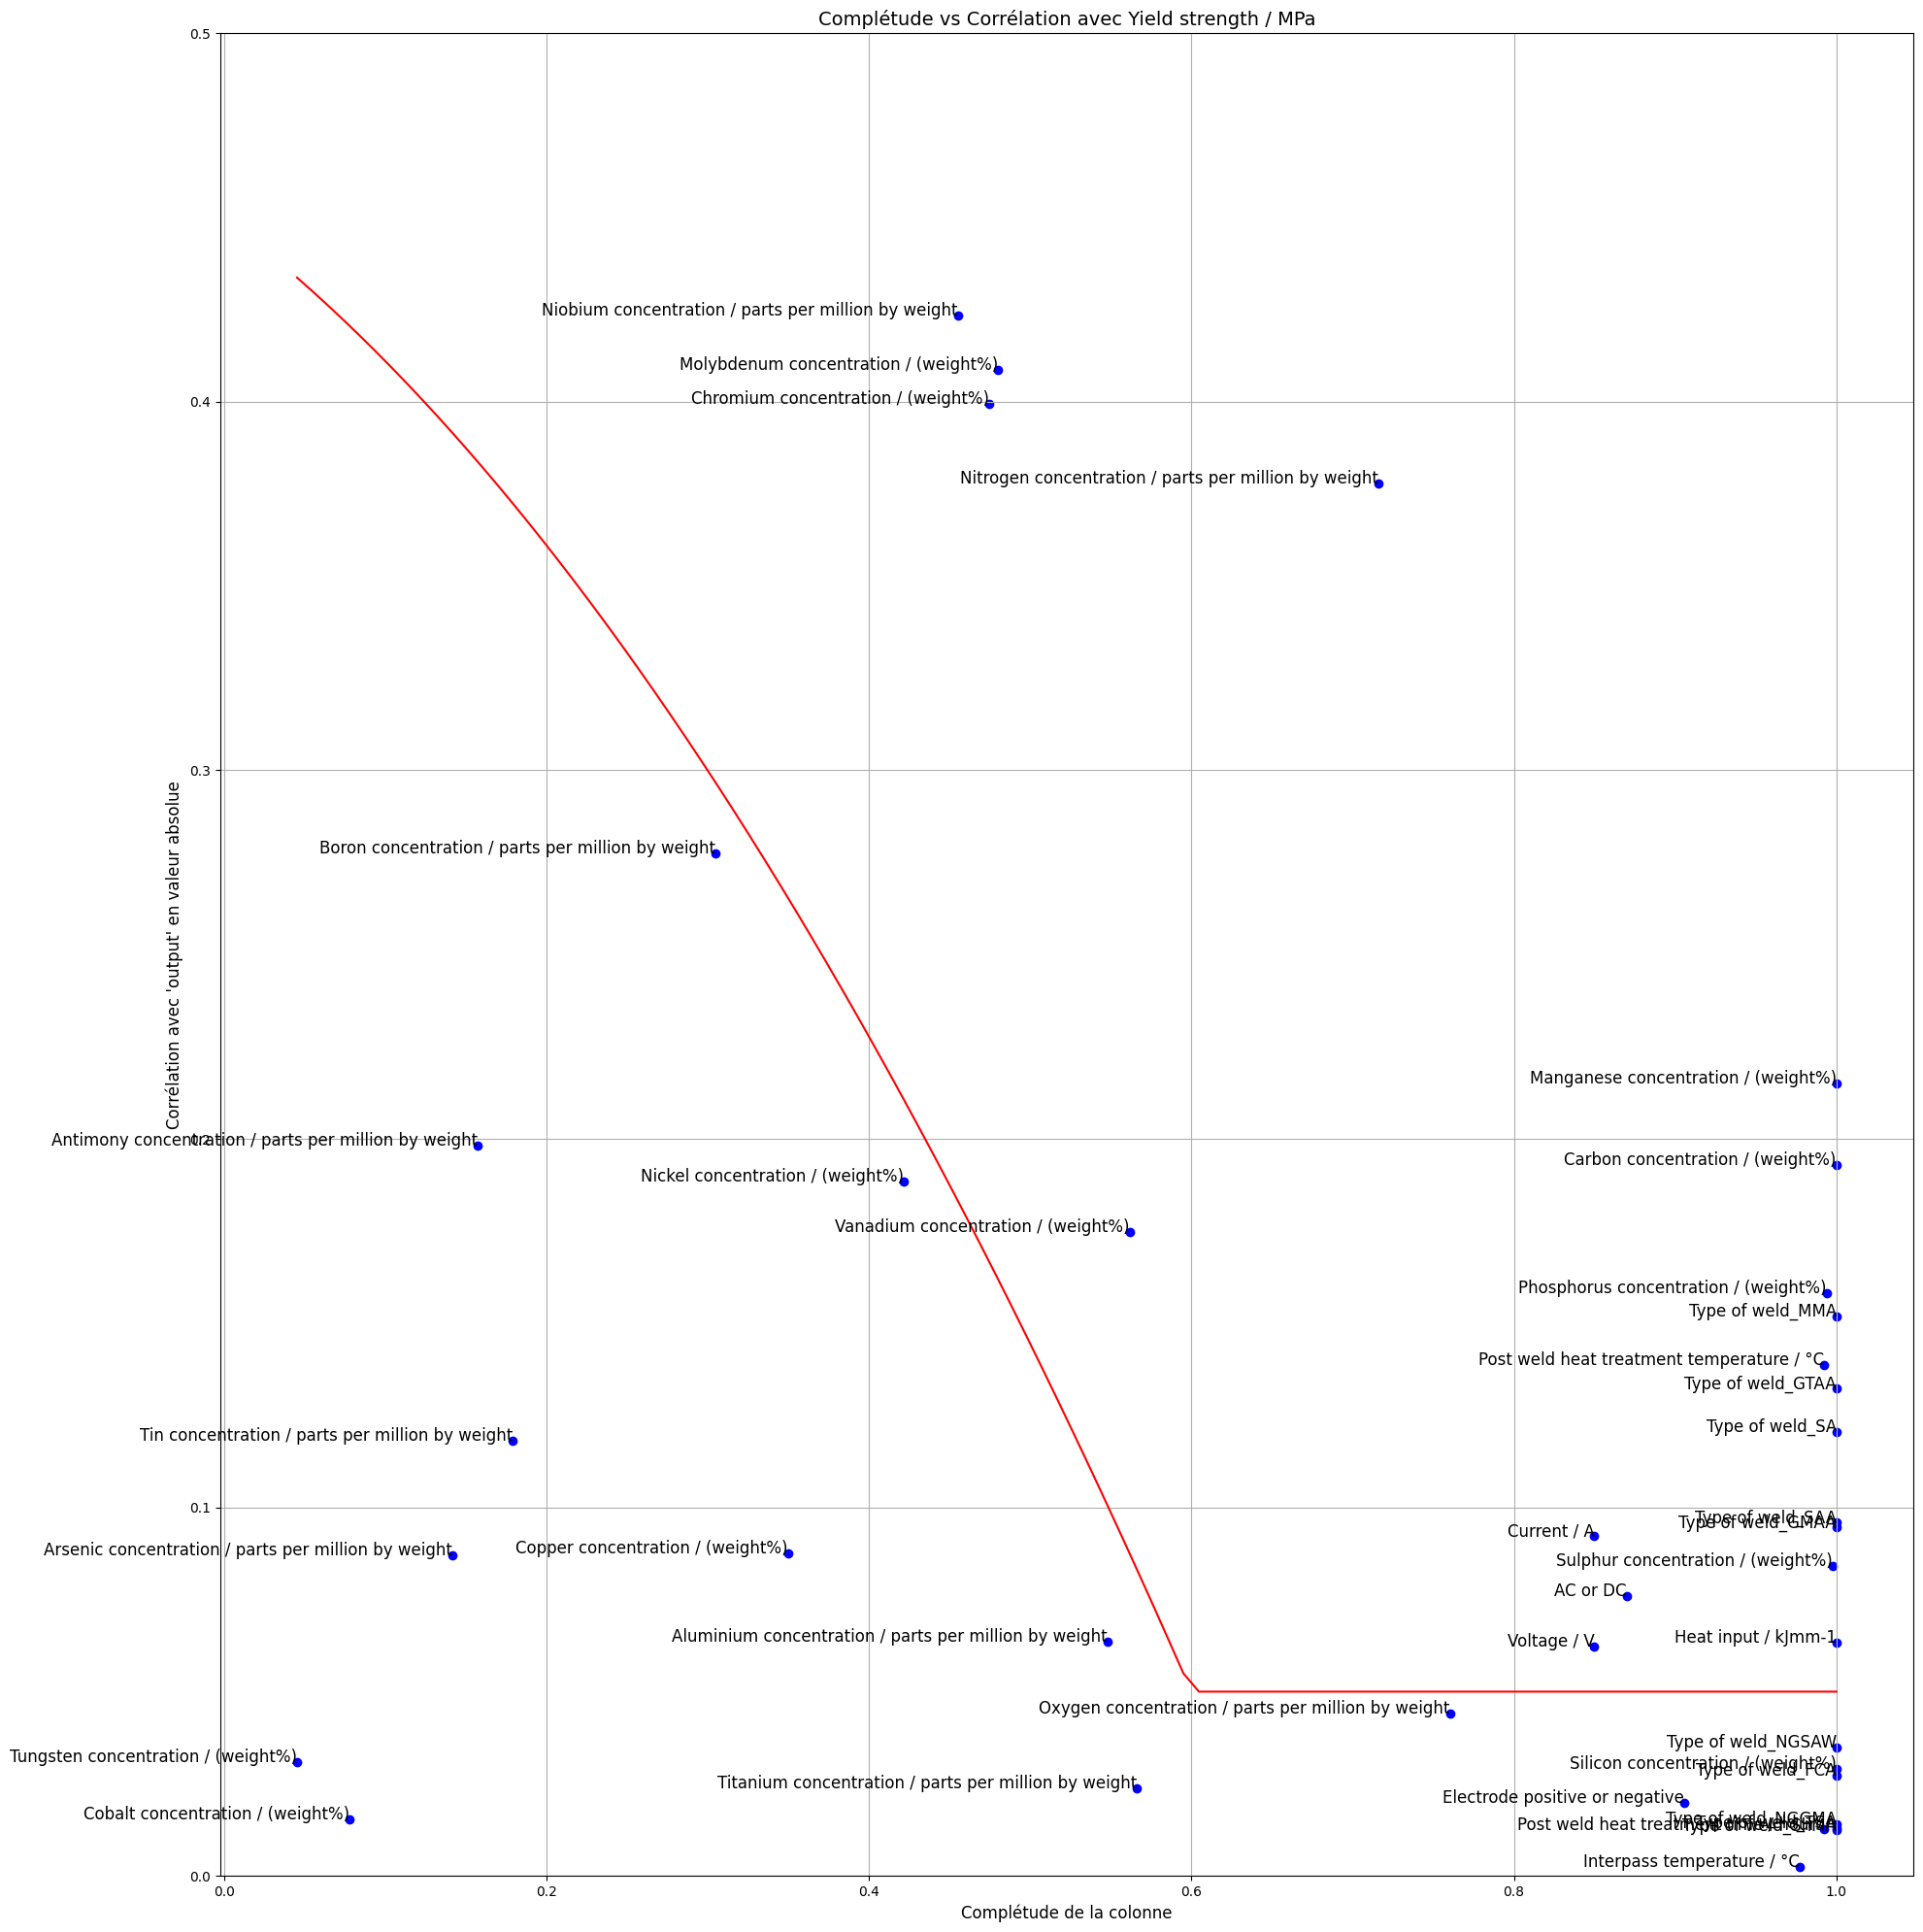

In [137]:
corr = get_corr(Db, 30)
features = plot_completeness_vs_corr(corr) + ['output']

In [124]:
Db[features].to_excel('relevant_features.xlsx')

In [141]:
print(features)

['Type of weld_SA', 'Voltage / V', 'Sulphur concentration / (weight%)', 'AC or DC', 'Niobium concentration / parts per million by weight', 'Current / A', 'Type of weld_MMA', 'Post weld heat treatment temperature / °C', 'Nitrogen concentration / parts per million by weight', 'Molybdenum concentration / (weight%)', 'Carbon concentration / (weight%)', 'Type of weld_SAA', 'Type of weld_GTAA', 'Chromium concentration / (weight%)', 'Vanadium concentration / (weight%)', 'Heat input / kJmm-1', 'Manganese concentration / (weight%)', 'Phosphorus concentration / (weight%)', 'Type of weld_GMAA', 'output']


In [77]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

Db_full=Db[features]
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp=IterativeImputer(max_iter=50, random_state=0)

imp.fit(Db_full)
Db_full = imp.transform(Db_full)
X=Db_full[:,:-1]
y=Db_full[:,-1]

c:\Users\linab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [73]:
pls2 = PLSRegression(n_components=19)
pls2.fit(X, y)
r2 = pls2.score(X, y)

print(f"R²: {r2}")
X_reduced = pls2.x_scores_
Y_pred = pls2.predict(X)


R²: 0.8396908210723235


Mean R² from Cross-Validation: 0.44


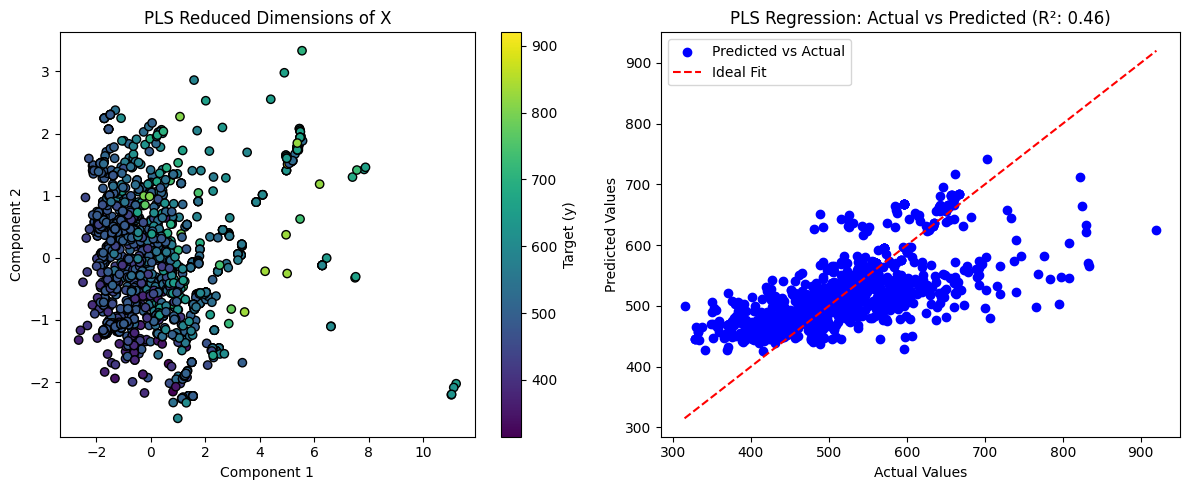

In [104]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.datasets import make_regression

# Initialize PLS Regression
n_components = 5
pls = PLSRegression(n_components=n_components)

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = cross_val_score(pls, X, y, cv=cv, scoring='r2')
# Fit the PLS model on the whole dataset
pls.fit(X, y)
# Predict values
Y_pred = pls.predict(X)
# Get reduced dimensions
X_reduced = pls.x_scores_
# Calculate the mean R² score
mean_r2 = np.mean(r2_scores)
print(f"Mean R² from Cross-Validation: {mean_r2:.2f}")
plot_PLS(pls, X, y)

Plotting Fold 1/2


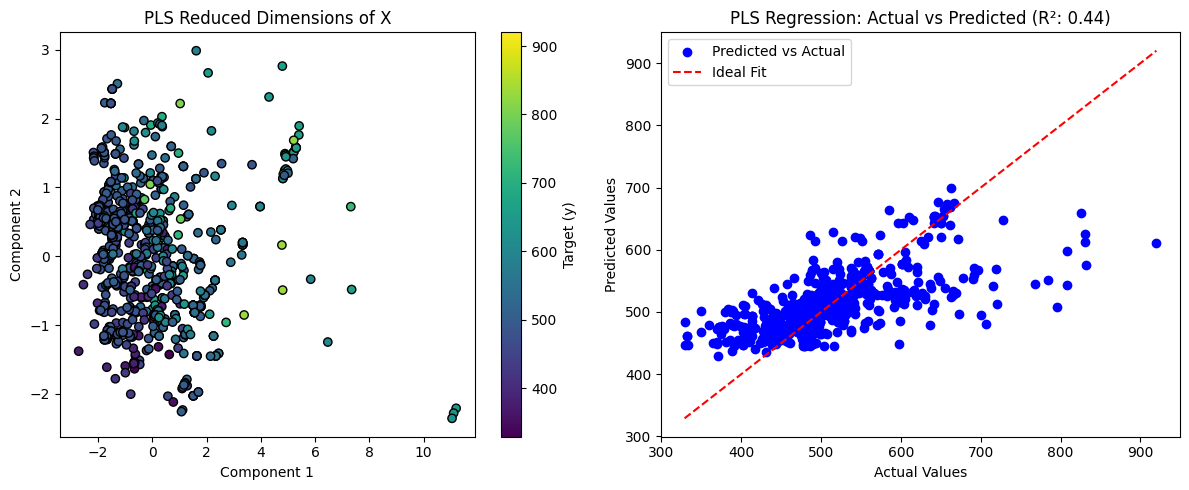

Plotting Fold 2/2


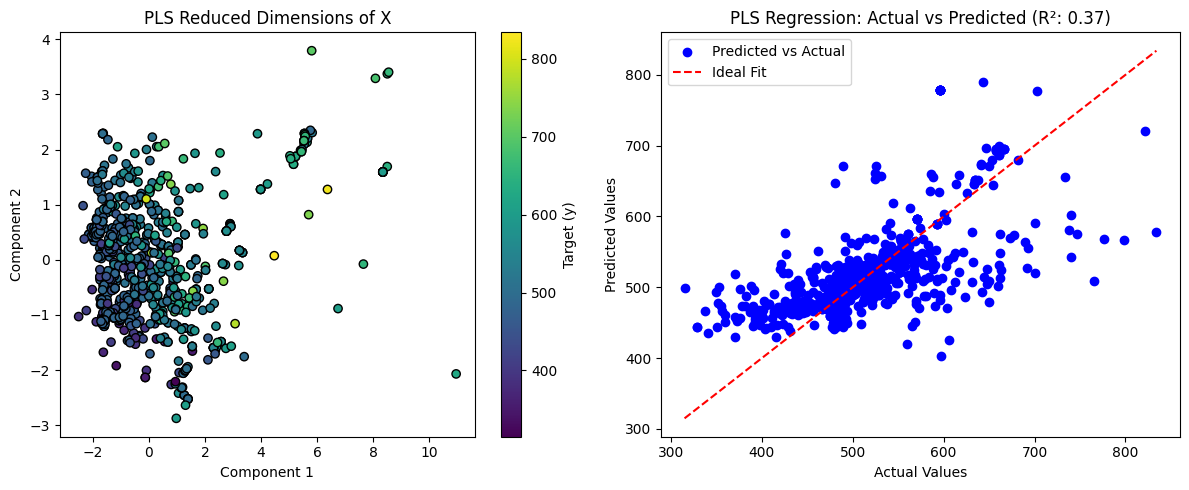

In [103]:
# Initialize K-Fold Cross-Validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Initialize PLS Regression
    pls = PLSRegression(n_components=5)

    # Fit the model
    pls.fit(X_train, y_train)

    # Plot the results for the current fold
    print(f"Plotting Fold {fold + 1}/{n_splits}")
    plot_PLS(pls, X_test, y_test)